In [1]:
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.utils import layer_utils
# from tensorflow.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pydot
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import os
for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


input/train_image_data_0.parquet
input/test_image_data_0.parquet
input/test_image_data_2.parquet
input/train_image_data_3.parquet
input/test_image_data_1.parquet
input/train_image_data_1.parquet
input/train.csv
input/train_image_data_2.parquet
input/test_image_data_3.parquet
input/test.csv
input/sample_submission.csv
input/class_map.csv


In [2]:
train_df_ = pd.read_csv('input/train.csv')
test_df_ = pd.read_csv('input/test.csv')
class_map_df = pd.read_csv('input/class_map.csv')
sample_sub_df = pd.read_csv('input/sample_submission.csv')

In [3]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (186, 3)


In [4]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    else:
        for i in range(df.shape[0]):
            image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
            resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

In [5]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [6]:
def identity_block(X, f, filters, stage, block):
    """
    ResNet Identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
def ResNet50(input_shape=(64, 64, 1), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [11]:
model_root = ResNet50(input_shape=(64, 64, 1), classes=168)
model_vowel = ResNet50(input_shape=(64, 64, 1), classes=11)
model_consonant = ResNet50(input_shape=(64, 64, 1), classes=7)

In [12]:
model_root.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vowel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_consonant.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
IMG_SIZE=64
N_CHANNELS=1
batch_size = 32
epochs = 11
model_dict = {
    'grapheme_root': model_root,
    'vowel_diacritic': model_vowel,
    'consonant_diacritic': model_consonant
}

In [15]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

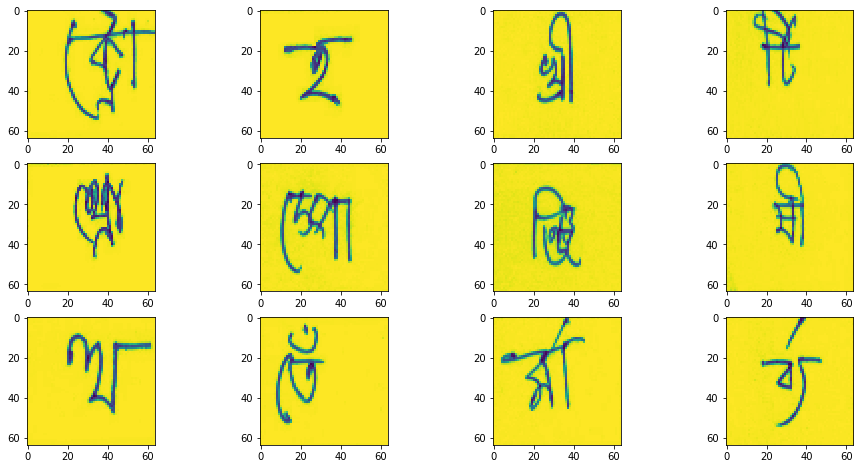


Training images: (50210, 64, 64, 1)
Training labels: (50210, 168)
Train on 45189 samples, validate on 5021 samples
Epoch 1/11
45189/45189 [==============================] - 245s 5ms/sample - loss: 4.9250 - accuracy: 0.0337 - val_loss: 6.6813 - val_accuracy: 0.0482
Epoch 2/11
45189/45189 [==============================] - 214s 5ms/sample - loss: 4.1302 - accuracy: 0.0853 - val_loss: 6.8753 - val_accuracy: 0.0251
Epoch 3/11
45189/45189 [==============================] - 214s 5ms/sample - loss: 2.9740 - accuracy: 0.2490 - val_loss: 3.4092 - val_accuracy: 0.2049
Epoch 4/11
45189/45189 [==============================] - 213s 5ms/sample - loss: 1.8373 - accuracy: 0.4871 - val_loss: 2.8438 - val_accuracy: 0.3324
Epoch 5/11
45189/45189 [==============================] - 213s 5ms/sample - loss: 1.2641 - accuracy: 0.6385 - val_loss: 1.6005 - val_accuracy: 0.5766
Epoch 6/11
45189/45189 [==============================] - 213s 5ms/sample - loss: 0.9878 - accuracy: 0.7097 - val_loss: 1.2307 - val_a

In [ ]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'input/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(64, 64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    for target in ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']:
        Y_train = train_df[target]
        Y_train = pd.get_dummies(Y_train).values

        print(f'Training images: {X_train.shape}')
        print(f'Training labels: {Y_train.shape}')
        
        # Divide the data into training and validation set
        x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.10, random_state=666)
        del Y_train
        history = model_dict[target].fit(x_train, 
                                         y_train, 
                                         batch_size=batch_size, 
                                         epochs=epochs, 
                                         callbacks=[learning_rate_reduction],
                                         validation_data=(x_test, y_test))
    
        del x_train
        del x_test
        del y_train
        del y_test    
        histories.append(history)
        gc.collect()
    # Delete to reduce memory usage
    del X_train
    del train_df
    gc.collect()

In [ ]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['accuracy'], label='train_acc')
    plt.plot(np.arange(0, epoch), his.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
for dataset in range(4):
    for target in ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']:
        plot_loss(histories[0], epochs, f'Dataset: {dataset}, Training on: {target}')
        plot_acc(histories[0], epochs, f'Dataset: {dataset}, Training on: {target}')

In [ ]:
del histories

In [ ]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [ ]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('input/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

    for pred in preds_dict:
        preds_dict[pred]=np.argmax(model_dict[pred].predict(X_test), axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()